# Focused Data Transformation: 
### Research Question: Does Light Pollution Affect Bird Migration? (Light Pollution --> Bird Migration)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

1. LOAD FULL DATASET (WITH WEATHER)

In [2]:
data_path = Path("../data/processed_data/birdcast+viirs+weather/merged_dataset_with_weather.csv")
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

print(f"\nOriginal dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")


Original dataset: 1542 rows × 33 columns
Columns: ['date', 'state', 'gapfilled_ntl', 'ntl_variability', 'lunar_irradiance', 'quality_score', 'total_passed', 'peak_birds', 'peak_direction', 'peak_speed_mph', 'peak_altitude_ft', 'day_of_year', 'month', 'year', 'season', 'peak_speed_missing', 'peak_altitude_missing', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)', 'cloud_cover (%)', 'surface_pressure (hPa)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'dew_point_2m (°C)', 'soil_temperature_0_to_7cm (°C)', 'rain (mm)', 'snowfall (cm)', 'wind_gusts_10m (km/h)', 'wind_speed_100m (km/h)', 'wind_direction_100m (°)', 'vapour_pressure_deficit (kPa)', 'hour']


2. IDENTIFY FEATURES TO TRANSFORM

In [3]:
print("~~~~~ FEATURE IDENTIFICATION ~~~~~")

# Features that need transformation (highly skewed)
skewed_features = {
    'Light': ['gapfilled_ntl', 'ntl_variability'],
    'Birds': ['total_passed', 'peak_birds'],
    'Behavior': ['peak_speed_mph', 'peak_altitude_ft'],
    'Natural': ['lunar_irradiance']
}

# Weather features (keep original - already reasonable distributions)
weather_features = [col for col in df.columns if any(term in col.lower() 
                   for term in ['temperature', 'humidity', 'cloud', 'wind', 
                                'rain', 'snow', 'pressure', 'soil', 'dew', 'vapour'])]

# Temporal features (keep as-is)
temporal_features = ['day_of_year', 'month', 'year', 'season', 'hour']

# Categorical features
categorical_features = ['state', 'peak_direction']

# Quality flags
flag_features = ['peak_speed_missing', 'peak_altitude_missing', 'quality_score']

print("\nWeather features found:")
for feat in weather_features:
    print(f"  - {feat}")

print(f"\nTotal weather features: {len(weather_features)}")

~~~~~ FEATURE IDENTIFICATION ~~~~~

Weather features found:
  - temperature_2m (°C)
  - relative_humidity_2m (%)
  - apparent_temperature (°C)
  - cloud_cover (%)
  - surface_pressure (hPa)
  - wind_speed_10m (km/h)
  - wind_direction_10m (°)
  - dew_point_2m (°C)
  - soil_temperature_0_to_7cm (°C)
  - rain (mm)
  - snowfall (cm)
  - wind_gusts_10m (km/h)
  - wind_speed_100m (km/h)
  - wind_direction_100m (°)
  - vapour_pressure_deficit (kPa)

Total weather features: 15


3. CREATE WORKING DATAFRAME (ALL FEATURES)

In [4]:
# Combine all feature lists
all_features_to_keep = (
    list(set([item for sublist in skewed_features.values() for item in sublist])) +
    weather_features +
    temporal_features +
    categorical_features +
    flag_features +
    ['date']
)

# Select only features that exist in dataframe
existing_features = [col for col in all_features_to_keep if col in df.columns]

df_full = df[existing_features].copy()

print(f"\nWorking dataset: {df_full.shape[0]} rows × {df_full.shape[1]} columns")


Working dataset: 1542 rows × 33 columns


4. HANDLE MISSING VALUES

In [5]:
print("~~~~~ HANDLING MISSING VALUES ~~~~~")

# Replace -1 sentinels with NaN for proper imputation
df_full['peak_speed_mph'] = df_full['peak_speed_mph'].replace(-1, np.nan)
df_full['peak_altitude_ft'] = df_full['peak_altitude_ft'].replace(-1, np.nan)

print("Missing values before imputation:")
missing_before = df_full.isnull().sum()
print(missing_before[missing_before > 0])

# Impute missing behavioral metrics with median
df_full['peak_speed_mph'].fillna(df_full['peak_speed_mph'].median(), inplace=True)
df_full['peak_altitude_ft'].fillna(df_full['peak_altitude_ft'].median(), inplace=True)

# Impute peak_direction if missing
if df_full['peak_direction'].isnull().any():
    df_full['peak_direction'].fillna('Low activity', inplace=True)

print("\nMissing values after imputation:")
missing_after = df_full.isnull().sum()
print(missing_after[missing_after > 0])

~~~~~ HANDLING MISSING VALUES ~~~~~
Missing values before imputation:
peak_speed_mph      330
peak_altitude_ft    330
dtype: int64

Missing values after imputation:
Series([], dtype: int64)


5. VISUALIZE ORIGINAL DISTRIBUTIONS

~~~~~ VISUALIZING ORIGINAL DISTRIBUTIONS ~~~~~
✓ Original distributions saved


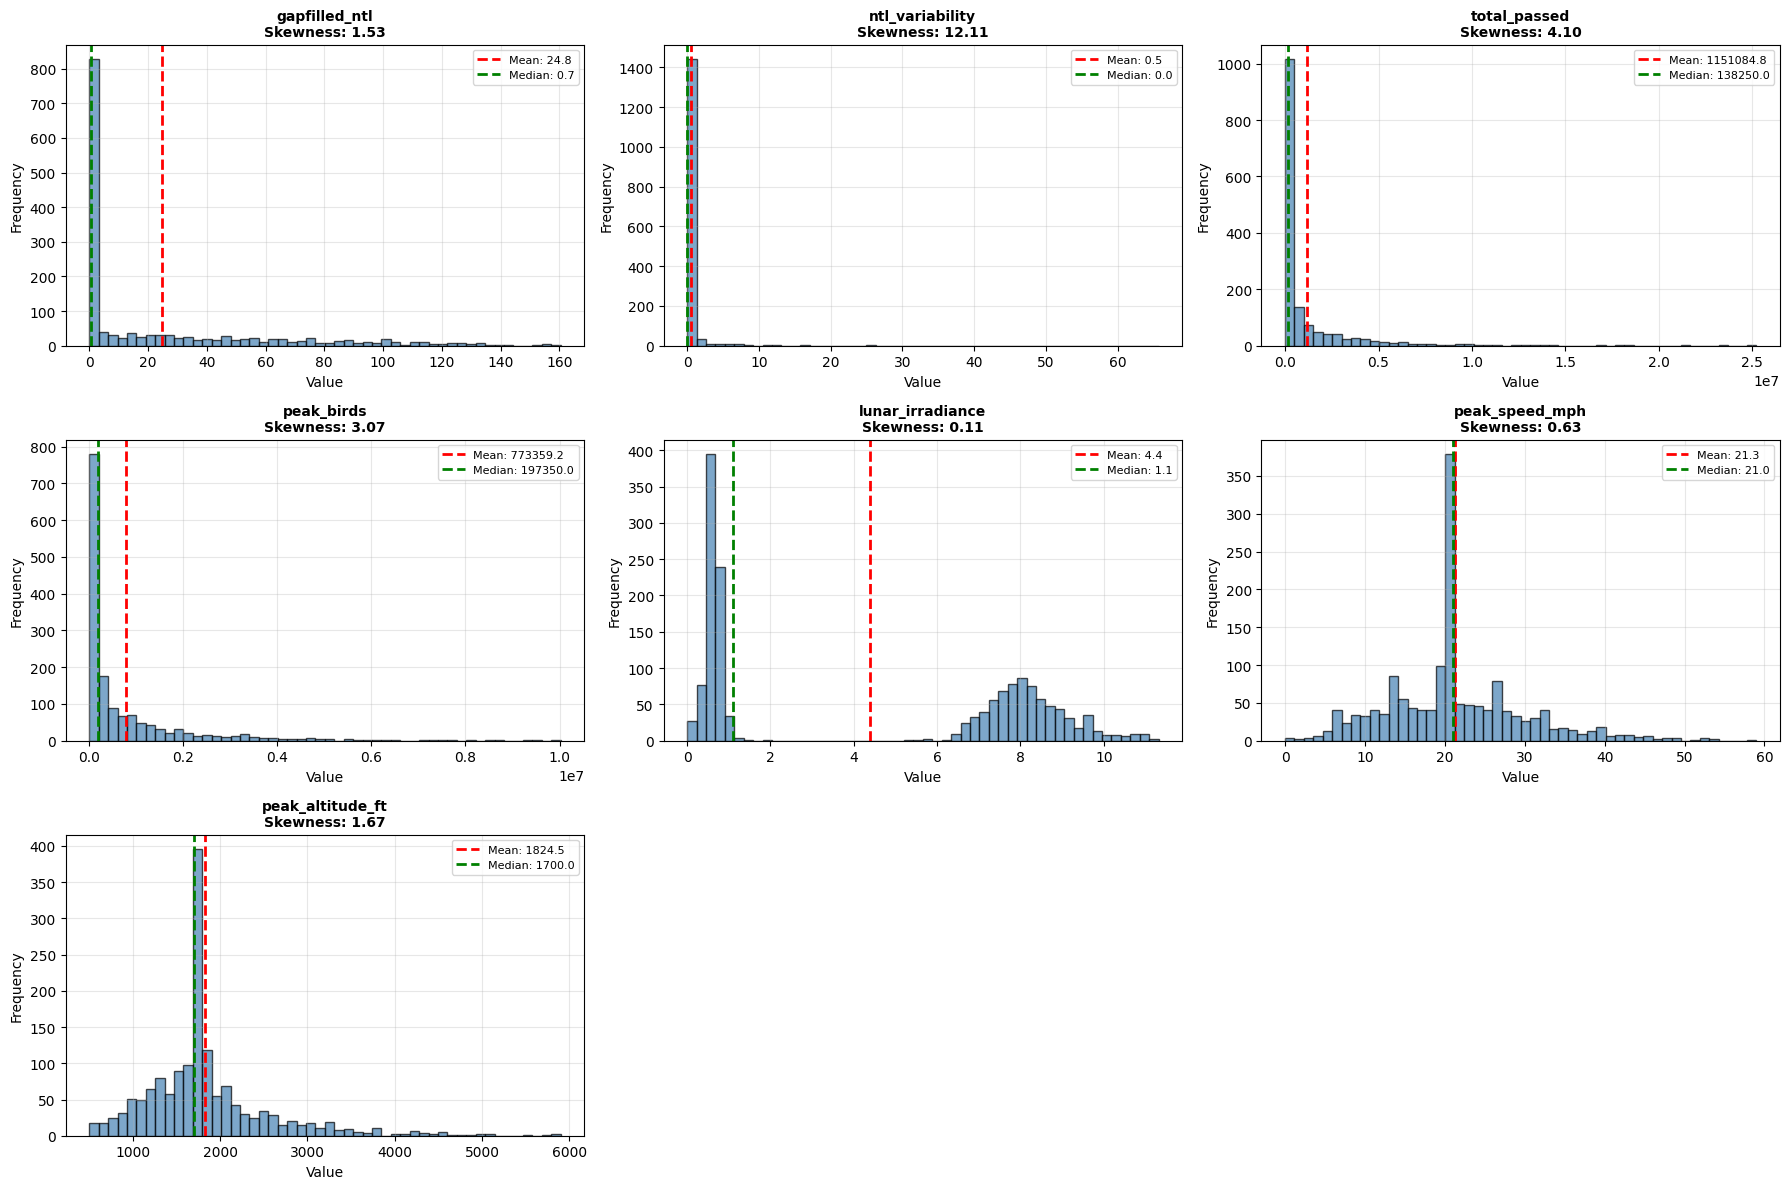

In [6]:
print("~~~~~ VISUALIZING ORIGINAL DISTRIBUTIONS ~~~~~")

output_dir = Path('../outputs/figures/transformations')
output_dir.mkdir(parents=True, exist_ok=True)

# Features to visualize
viz_features = ['gapfilled_ntl', 'ntl_variability', 'total_passed', 'peak_birds', 
                'lunar_irradiance', 'peak_speed_mph', 'peak_altitude_ft']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(viz_features):
    if col in df_full.columns:
        data = df_full[col].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Histogram
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        skew_val = stats.skew(data)
        axes[idx].set_title(f'{col}\nSkewness: {skew_val:.2f}', 
                           fontweight='bold', fontsize=10)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
        
        # Add mean and median lines
        axes[idx].axvline(data.mean(), color='red', linestyle='--', 
                         linewidth=2, label=f'Mean: {data.mean():.1f}')
        axes[idx].axvline(data.median(), color='green', linestyle='--', 
                         linewidth=2, label=f'Median: {data.median():.1f}')
        axes[idx].legend(fontsize=8)

# Remove empty subplots
for idx in range(len(viz_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(output_dir / 'original_distributions_all_features.png', dpi=300, bbox_inches='tight')
print("✓ Original distributions saved")
plt.show()


6. APPLY TRANSFORMATIONS

In [7]:
transformation_log = {}

# LOG TRANSFORMATION for right-skewed features
print("\n[1] LOG TRANSFORMATION")
log_features = ['gapfilled_ntl', 'ntl_variability', 'total_passed', 'peak_birds']

for feature in log_features:
    if feature in df_full.columns:
        original = df_full[feature].replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(original) > 0 and (original >= 0).all():
            transformed_col = f'{feature}_log'
            df_full[transformed_col] = np.log1p(df_full[feature])
            
            new_skew = stats.skew(df_full[transformed_col].dropna())
            original_skew = stats.skew(original)
            
            transformation_log[feature] = {
                'method': 'log1p',
                'new_column': transformed_col,
                'original_skew': original_skew,
                'new_skew': new_skew
            }
            
            print(f"✓ {feature:20s}: Skew {original_skew:7.3f} → {new_skew:7.3f}")

# YEO-JOHNSON TRANSFORMATION for features with zeros/negatives
print("\n[2] YEO-JOHNSON TRANSFORMATION")
pt = PowerTransformer(method='yeo-johnson', standardize=False)
yj_features = ['lunar_irradiance', 'peak_speed_mph', 'peak_altitude_ft']

for feature in yj_features:
    if feature in df_full.columns:
        original = df_full[feature].replace([np.inf, -np.inf], np.nan)
        mask = original.notna()
        
        if mask.sum() > 0:
            transformed_col = f'{feature}_yj'
            
            transformed_values = pt.fit_transform(original[mask].values.reshape(-1, 1))
            
            df_full[transformed_col] = np.nan
            df_full.loc[mask, transformed_col] = transformed_values.flatten()
            
            new_skew = stats.skew(df_full[transformed_col].dropna())
            original_skew = stats.skew(original.dropna())
            
            transformation_log[feature] = {
                'method': 'yeo-johnson',
                'new_column': transformed_col,
                'original_skew': original_skew,
                'new_skew': new_skew
            }
            
            print(f"✓ {feature:20s}: Skew {original_skew:7.3f} → {new_skew:7.3f}")



[1] LOG TRANSFORMATION
✓ gapfilled_ntl       : Skew   1.528 →   0.426
✓ ntl_variability     : Skew  12.110 →   4.168
✓ total_passed        : Skew   4.105 →  -0.379
✓ peak_birds          : Skew   3.069 →  -0.030

[2] YEO-JOHNSON TRANSFORMATION
✓ lunar_irradiance    : Skew   0.114 →   0.004
✓ peak_speed_mph      : Skew   0.632 →   0.042
✓ peak_altitude_ft    : Skew   1.672 →   0.003


7. VISUALIZE TRANSFORMATION EFFECTS

~~~~~ VISUALIZING TRANSFORMATION EFFECTS ~~~~~
✓ Transformation comparison saved


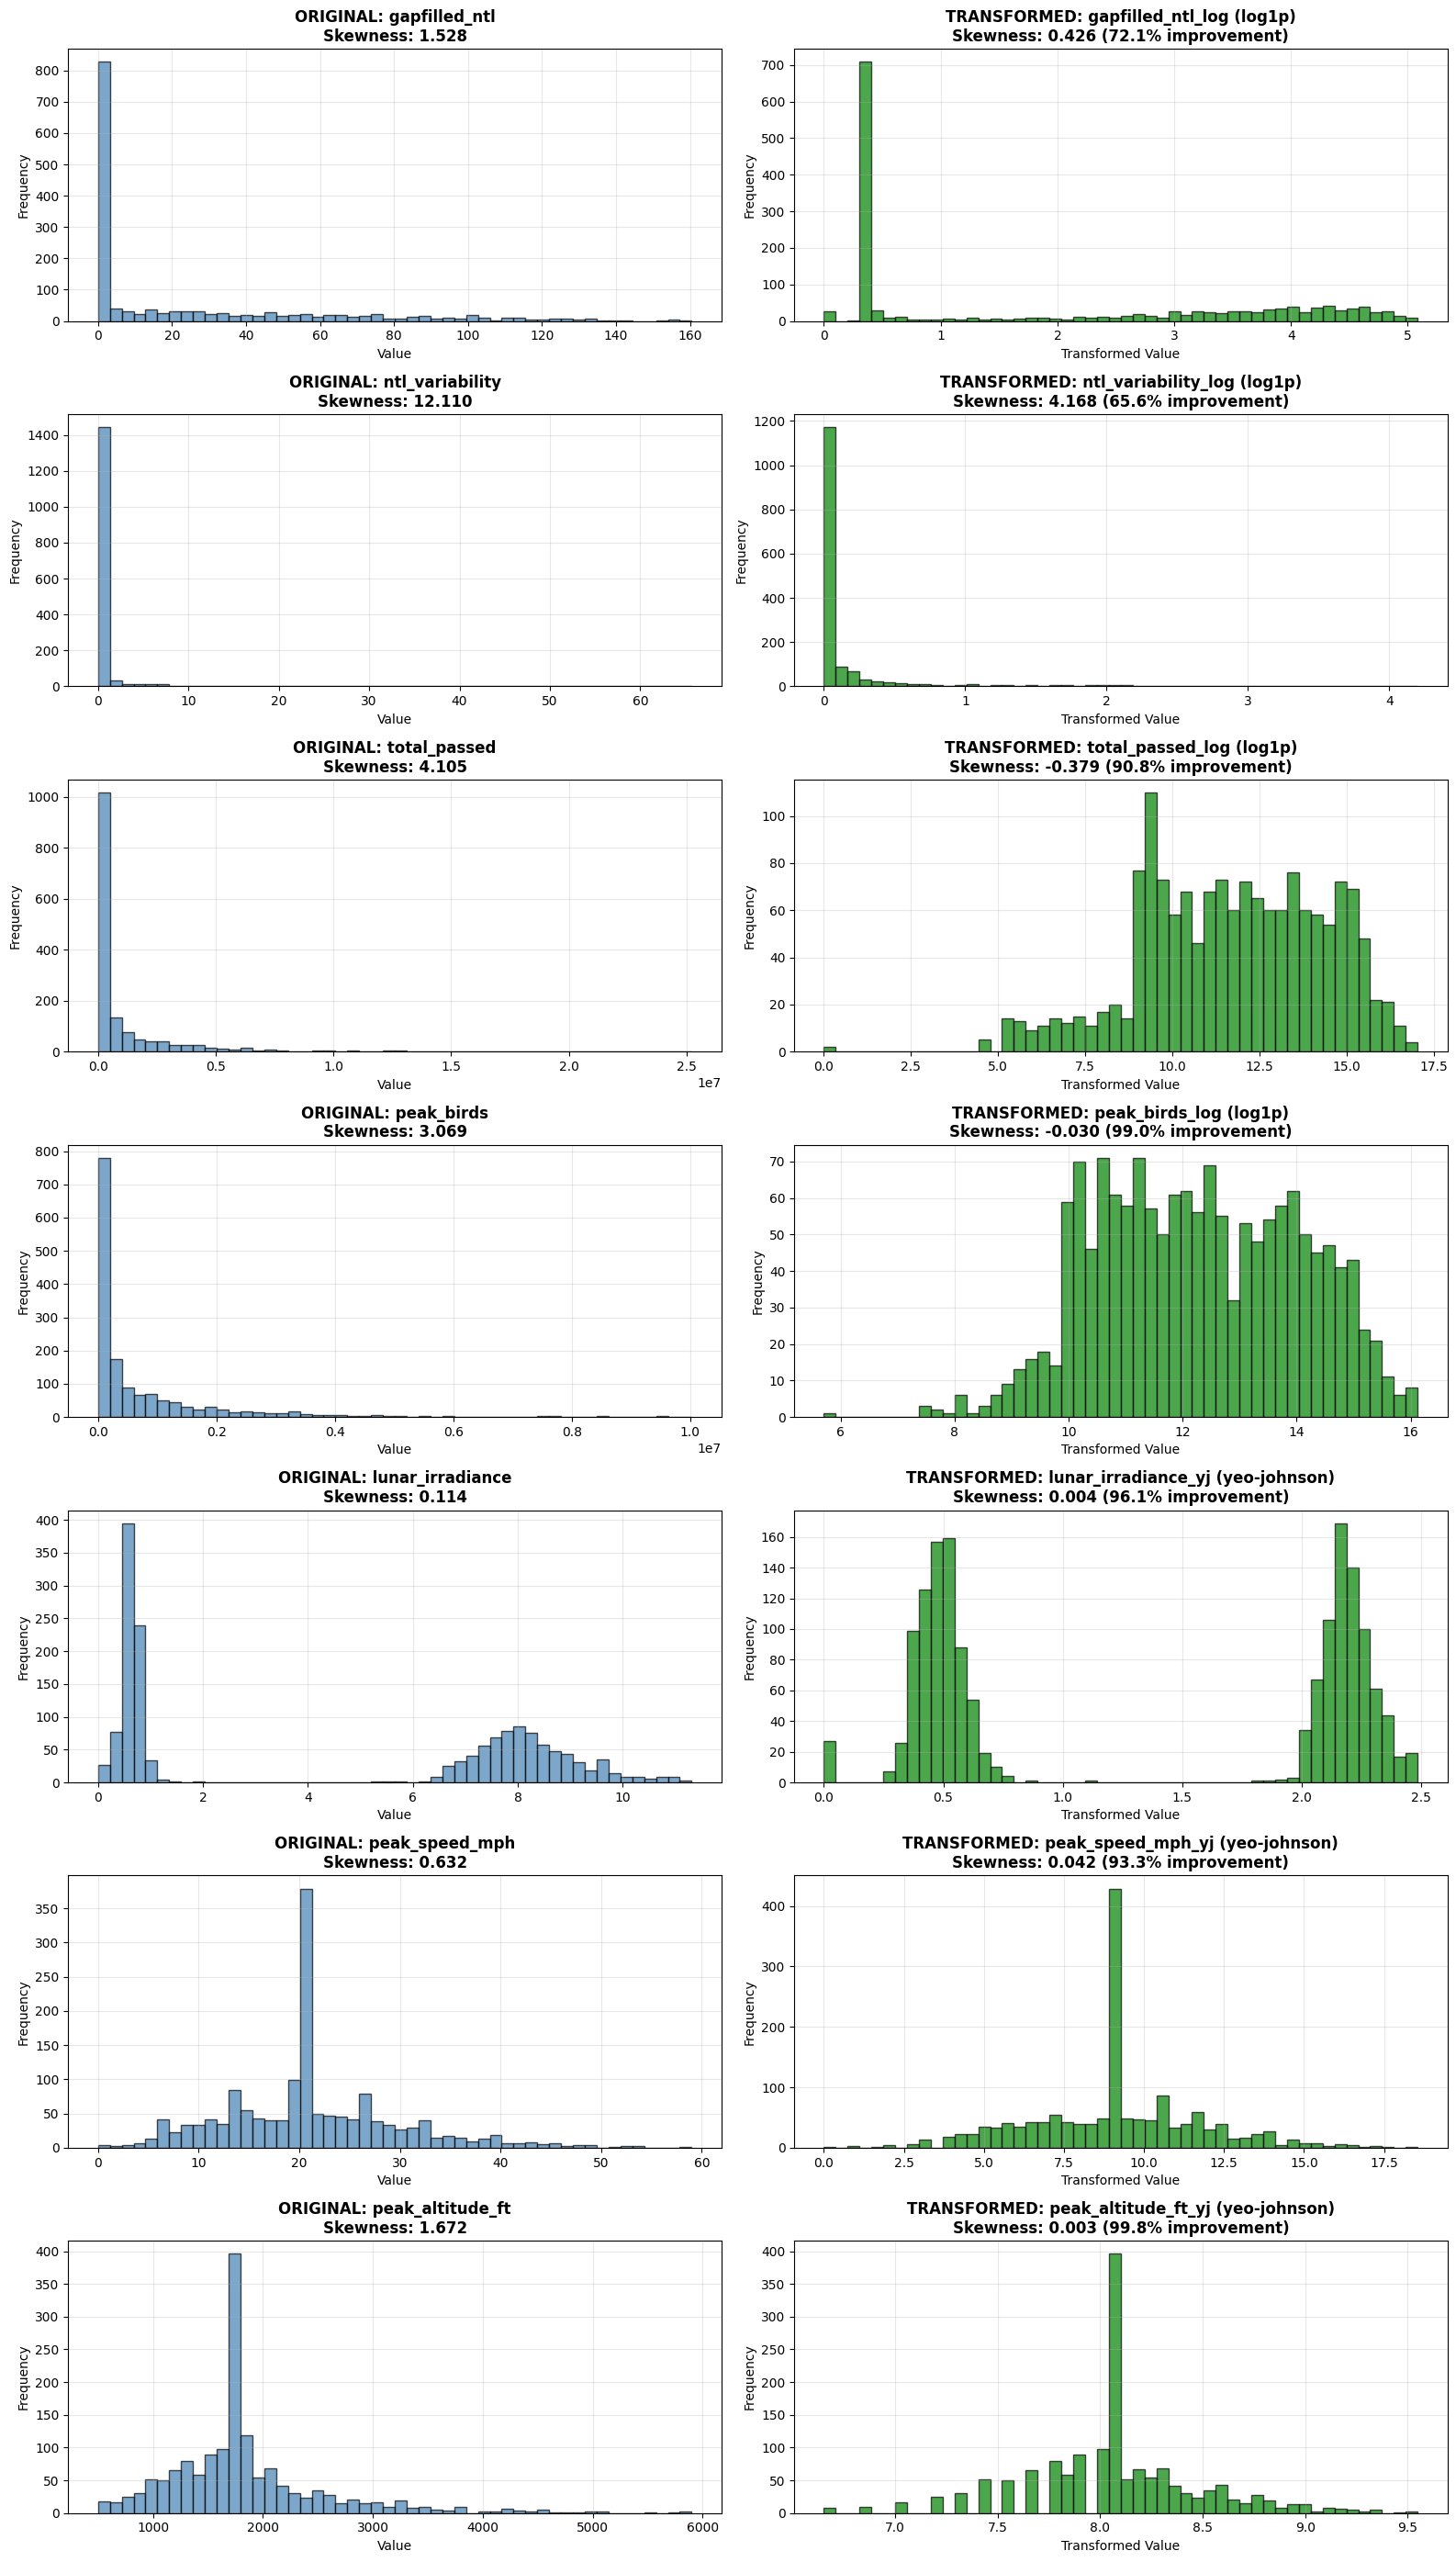

In [8]:
print("~~~~~ VISUALIZING TRANSFORMATION EFFECTS ~~~~~")

transformed_features = list(transformation_log.keys())

fig, axes = plt.subplots(len(transformed_features), 2, figsize=(16, 4*len(transformed_features)))

for idx, feature in enumerate(transformed_features):
    # Original
    original_data = df_full[feature].replace([np.inf, -np.inf], np.nan).dropna()
    axes[idx, 0].hist(original_data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx, 0].set_title(f'ORIGINAL: {feature}\nSkewness: {transformation_log[feature]["original_skew"]:.3f}',
                          fontweight='bold', fontsize=12)
    axes[idx, 0].set_xlabel('Value')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Transformed
    transformed_col = transformation_log[feature]['new_column']
    transformed_data = df_full[transformed_col].dropna()
    axes[idx, 1].hist(transformed_data, bins=50, edgecolor='black', alpha=0.7, color='green')
    improvement = ((abs(transformation_log[feature]["original_skew"]) - 
                   abs(transformation_log[feature]["new_skew"])) / 
                  abs(transformation_log[feature]["original_skew"]) * 100 
                  if transformation_log[feature]["original_skew"] != 0 else 0)
    axes[idx, 1].set_title(f'TRANSFORMED: {transformed_col} ({transformation_log[feature]["method"]})\n'
                          f'Skewness: {transformation_log[feature]["new_skew"]:.3f} '
                          f'({improvement:.1f}% improvement)',
                          fontweight='bold', fontsize=12)
    axes[idx, 1].set_xlabel('Transformed Value')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'transformation_comparison_full.png', dpi=300, bbox_inches='tight')
print("✓ Transformation comparison saved")
plt.show()

8. SKEWNESS IMPROVEMENT SUMMARY

~~~~~ SKEWNESS IMPROVEMENT SUMMARY ~~~~~
         Feature      Method  Original_Skew  New_Skew  Improvement_%
peak_altitude_ft yeo-johnson       1.672218  0.002947      99.823763
      peak_birds       log1p       3.069429 -0.029973      99.023501
lunar_irradiance yeo-johnson       0.113807  0.004441      96.097578
  peak_speed_mph yeo-johnson       0.632206  0.042238      93.318904
    total_passed       log1p       4.104994 -0.379387      90.757915
   gapfilled_ntl       log1p       1.528439  0.426225      72.113734
 ntl_variability       log1p      12.109931  4.167629      65.585034
✓ Skewness improvement plot saved


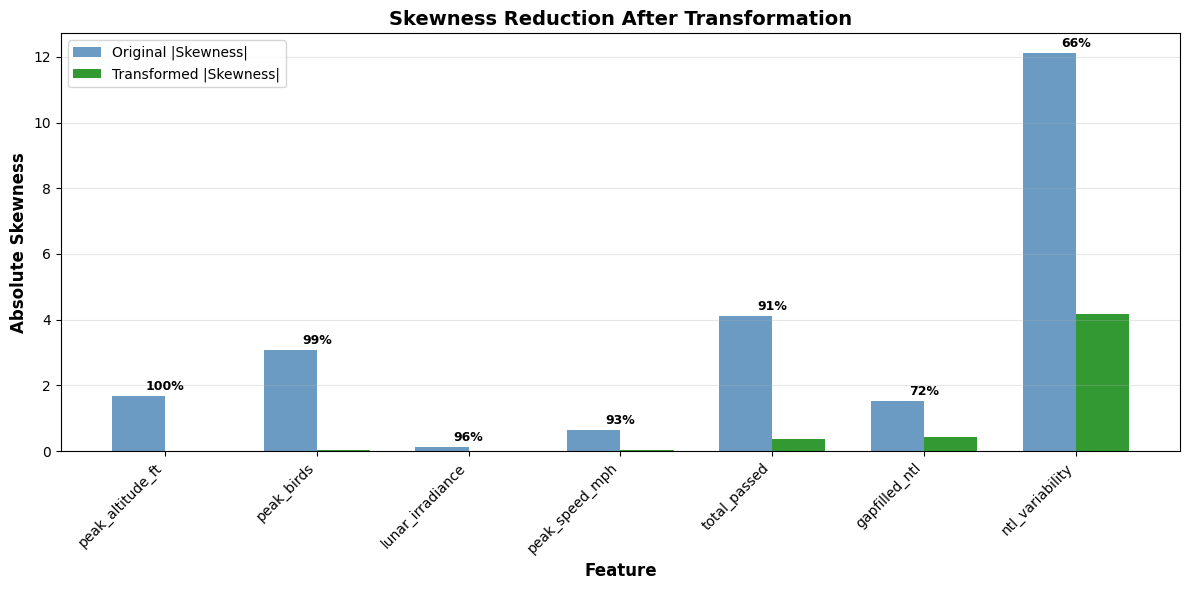

In [9]:
print("~~~~~ SKEWNESS IMPROVEMENT SUMMARY ~~~~~")

summary_data = []
for feature, info in transformation_log.items():
    improvement = ((abs(info['original_skew']) - abs(info['new_skew'])) / 
                  abs(info['original_skew']) * 100 if info['original_skew'] != 0 else 0)
    summary_data.append({
        'Feature': feature,
        'Method': info['method'],
        'Original_Skew': info['original_skew'],
        'New_Skew': info['new_skew'],
        'Improvement_%': improvement
    })

summary_df = pd.DataFrame(summary_data).sort_values('Improvement_%', ascending=False)
print(summary_df.to_string(index=False))

# Visualize improvement
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(summary_df))
width = 0.35

bars1 = ax.bar(x - width/2, abs(summary_df['Original_Skew']), width, 
               label='Original |Skewness|', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, abs(summary_df['New_Skew']), width, 
               label='Transformed |Skewness|', color='green', alpha=0.8)

ax.set_xlabel('Feature', fontweight='bold', fontsize=12)
ax.set_ylabel('Absolute Skewness', fontweight='bold', fontsize=12)
ax.set_title('Skewness Reduction After Transformation', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add improvement percentage labels
for i, (orig, new, imp) in enumerate(zip(abs(summary_df['Original_Skew']), 
                                          abs(summary_df['New_Skew']), 
                                          summary_df['Improvement_%'])):
    ax.text(i, max(orig, new) + 0.1, f'{imp:.0f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'skewness_improvement_summary.png', dpi=300, bbox_inches='tight')
print("✓ Skewness improvement plot saved")
plt.show()

9. CREATE DERIVED FEATURES

In [10]:
print("~~~~~ CREATING DERIVED FEATURES ~~~~~")

# Binary disorientation indicator
df_full['disoriented'] = (df_full['peak_direction'] == 'Low activity').astype(int)
print("✓ Created 'disoriented' binary target")

# Weather categories
if 'cloud_cover (%)' in df_full.columns:
    df_full['weather_condition'] = pd.cut(
        df_full['cloud_cover (%)'], 
        bins=[0, 30, 70, 100],
        labels=['Clear', 'Partly_Cloudy', 'Overcast']
    )
    print("✓ Created 'weather_condition' categories")

# Interaction features (for ML models)
if 'gapfilled_ntl_log' in df_full.columns and 'cloud_cover (%)' in df_full.columns:
    df_full['alan_cloud_interaction'] = df_full['gapfilled_ntl_log'] * df_full['cloud_cover (%)']
    print("✓ Created 'alan_cloud_interaction' feature")

if 'gapfilled_ntl_log' in df_full.columns and 'lunar_irradiance_yj' in df_full.columns:
    df_full['alan_lunar_interaction'] = df_full['gapfilled_ntl_log'] * df_full['lunar_irradiance_yj']
    print("✓ Created 'alan_lunar_interaction' feature")


~~~~~ CREATING DERIVED FEATURES ~~~~~
✓ Created 'disoriented' binary target
✓ Created 'weather_condition' categories
✓ Created 'alan_cloud_interaction' feature
✓ Created 'alan_lunar_interaction' feature


10. CORRELATION ANALYSIS

~~~~~ CORRELATION ANALYSIS ~~~~~
✓ Correlation matrix saved


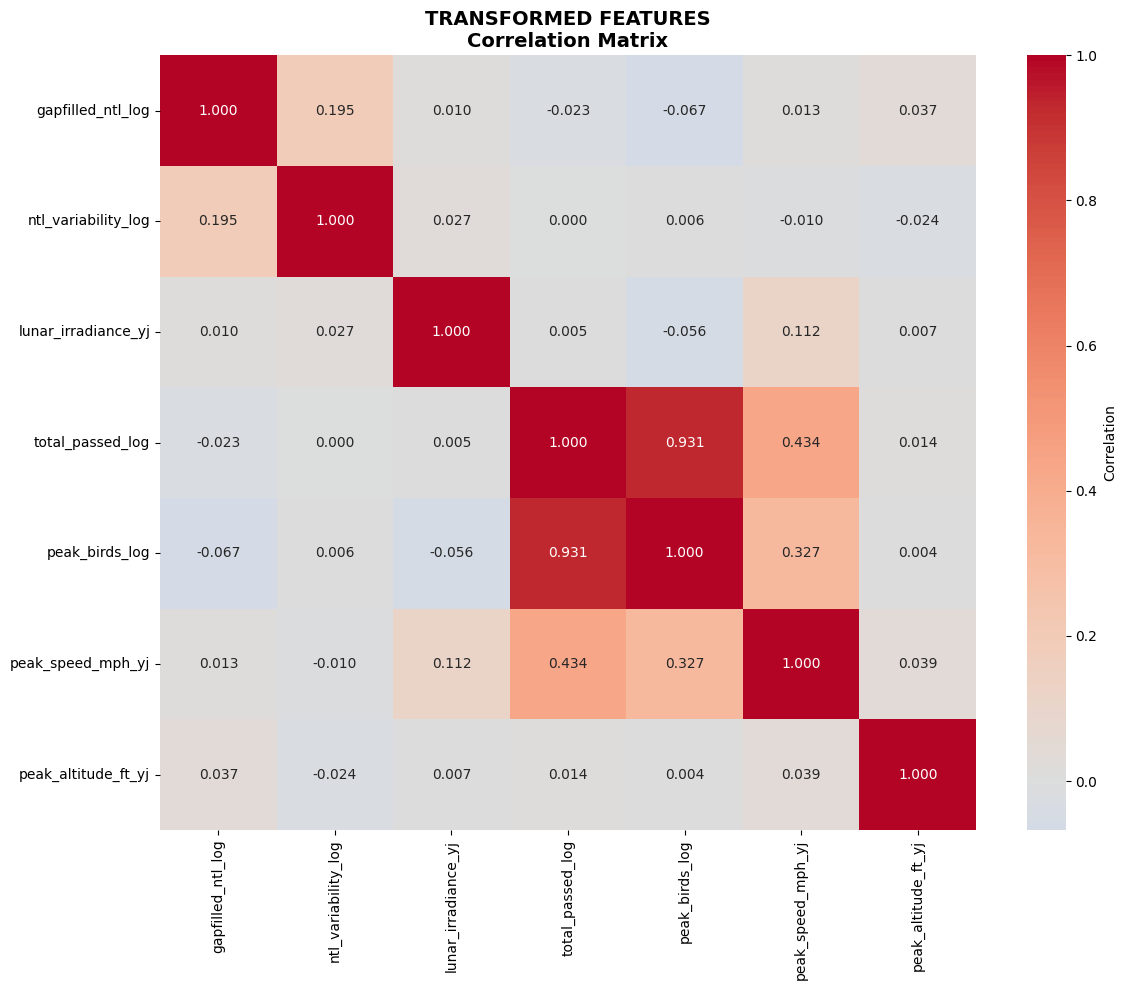


Top correlations with peak_birds_log:
peak_birds_log         1.000000
total_passed_log       0.930575
peak_speed_mph_yj      0.326709
ntl_variability_log    0.006392
peak_altitude_ft_yj    0.003845
lunar_irradiance_yj   -0.055506
gapfilled_ntl_log     -0.067183
Name: peak_birds_log, dtype: float64


In [11]:
print("~~~~~ CORRELATION ANALYSIS ~~~~~")

# Select key transformed features for correlation
corr_features = ['gapfilled_ntl_log', 'ntl_variability_log', 'lunar_irradiance_yj',
                'total_passed_log', 'peak_birds_log', 'peak_speed_mph_yj', 
                'peak_altitude_ft_yj']

# Filter to existing columns
corr_features = [f for f in corr_features if f in df_full.columns]

if len(corr_features) > 2:
    corr_matrix = df_full[corr_features].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('TRANSFORMED FEATURES\nCorrelation Matrix', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / 'correlation_matrix_transformed.png', dpi=300, bbox_inches='tight')
    print("✓ Correlation matrix saved")
    plt.show()
    
    # Print top correlations with peak_birds_log
    if 'peak_birds_log' in corr_features:
        print("\nTop correlations with peak_birds_log:")
        correlations = corr_matrix['peak_birds_log'].sort_values(ascending=False)
        print(correlations)


11. SAVE TRANSFORMED DATASET

In [12]:
print("~~~~~ SAVING TRANSFORMED DATASET ~~~~~")

output_path = Path("../data/processed_data/birdcast+viirs+weather/merged_dataset_transformed_FULL.csv")
df_full.to_csv(output_path, index=False)

print(f"\n✓ Transformed dataset saved: {output_path}")
print(f"  Dimensions: {df_full.shape[0]} rows × {df_full.shape[1]} columns")

print("\n✓ Dataset includes:")
print(f"  - Original features: {len(existing_features)}")
print(f"  - Transformed features: {len(transformation_log)} (created {len(transformation_log)} new columns)")
print(f"  - Weather features: {len(weather_features)}")
print(f"  - Derived features: disoriented, weather_condition, interactions")

~~~~~ SAVING TRANSFORMED DATASET ~~~~~

✓ Transformed dataset saved: ..\data\processed_data\birdcast+viirs+weather\merged_dataset_transformed_FULL.csv
  Dimensions: 1542 rows × 44 columns

✓ Dataset includes:
  - Original features: 33
  - Transformed features: 7 (created 7 new columns)
  - Weather features: 15
  - Derived features: disoriented, weather_condition, interactions


12. VERIFICATION

In [13]:
print("~~~~~ VERIFICATION ~~~~~")

print("\nKey columns present:")
required_cols = ['gapfilled_ntl_log', 'cloud_cover (%)', 'disoriented', 
                 'weather_condition', 'peak_direction', 'state']
for col in required_cols:
    status = "✓" if col in df_full.columns else "✗ MISSING"
    print(f"  {col:30s}: {status}")

print("\nSample data:")
sample_cols = [c for c in ['date', 'state', 'gapfilled_ntl', 'gapfilled_ntl_log', 
                            'cloud_cover (%)', 'disoriented', 'weather_condition'] 
               if c in df_full.columns]
print(df_full[sample_cols].head(3))

~~~~~ VERIFICATION ~~~~~

Key columns present:
  gapfilled_ntl_log             : ✓
  cloud_cover (%)               : ✓
  disoriented                   : ✓
  weather_condition             : ✓
  peak_direction                : ✓
  state                         : ✓

Sample data:
        date state  gapfilled_ntl  gapfilled_ntl_log  cloud_cover (%)  \
0 2021-03-23    NJ      24.047034           3.220755        81.857143   
1 2021-03-23    VT      24.022632           3.219781        78.714286   
2 2021-03-24    NJ      34.063942           3.557173        99.769231   

   disoriented weather_condition  
0            1          Overcast  
1            0          Overcast  
2            0          Overcast  
